
### Project Description:

1km x 1km satellite images in both 3-band and 16-band formats are provided and the goal is to detect and classify the types of objects found in these regions. 16-band images are furthur provided into 2 different 8-band image files. These bands are denoted as A, M and P bands.   

[Data Link](https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/data)

In the project, we will utilize the images from the M band (8 channel image files) to build an image segmentation model to classify and detect 10 classes in the satellite images. These 10 classes are as following:

1. Buildings - large building, residential, non-residential, fuel storage facility, fortified building
2. Misc. Manmade structures 
3. Road 
4. Track - poor/dirt/cart track, footpath/trail
5. Trees - woodland, hedgerows, groups of trees, standalone trees
6. Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
7. Waterway 
8. Standing water
9. Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
10. Vehicle Small - small vehicle (car, van), motorbike

The label information is provided in WKT format and we will have to generate image mask for all training data using this information by ourselves.

In [1]:
# Importing all libraries

import os
import shutil
import tifffile as tiff
import pandas as pd
import numpy as np
from random import randint
import cv2
import matplotlib.pyplot as plt
from shapely.wkt import loads as wkt_loads
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.layers import Input, Activation, Conv2D, MaxPool2D, Conv2DTranspose, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# size of image to be feed into resnet encoder for Unet structure Neural Network
img_size_nn = 240

# Number of output channels which are same as output classes, later on we will add extra class which will be None of the 10 available classes
opt_cls = 10

# data directory and loading csv files; also, same directory will be used to save data while preparing images for modelling
dat_dir = '/Users/ritayu/Downloads/dstl-satellite-imagery-feature-detection/'
train_df = pd.read_csv(dat_dir+'train_wkt_v4.csv')
grid_df = pd.read_csv(dat_dir+'grid_sizes.csv', header = 0, names = ['ImageId','Xmax', 'Ymin'])


In [106]:
train_df.head()

,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...


In [108]:
grid_df.head()

,ImageId,Xmax,Ymin
0,6120_2_4,0.009180,-0.00904
1,6120_2_3,0.009169,-0.00904
2,6120_2_2,0.009188,-0.00904
3,6120_2_1,0.009188,-0.00904
4,6120_2_0,0.009188,-0.00904


Exploring the dimensions of various satellite images:

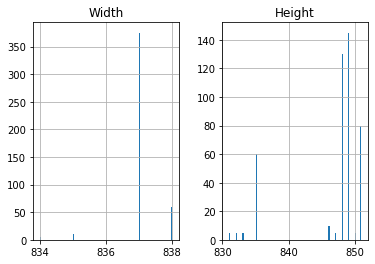

In [3]:
def plot_img_dim(dat_dir):
    image_w = []
    image_h = []
    unique_img_id = list(grid_df['ImageId'].unique())
    for img_id in unique_img_id:
        img = tiff.imread(dat_dir+'sixteen_band/'+ str(img_id) + '_M.tif')
        image_w.append(img.shape[1])
        image_h.append(img.shape[2])
    image_w = pd.DataFrame(image_w, columns = ['Width'])
    image_h = pd.DataFrame(image_h, columns = ['Height'])
    fig, axes = plt.subplots(1, 2)
    image_w.hist('Width', bins=100, ax=axes[0])
    image_h.hist('Height', bins=100, ax=axes[1])

plot_img_dim(dat_dir)

Looks like 832x832 size will be possible for all the images as minimum dimension of any image is 832

Defining functions that incorporate the image data preprocessing part:   

In [4]:
# function to read polygons from the train file
# WKT format used in the csv files includes coordinates for external and interior coordinates that can be read using shapely library
def polygon_data(img_id, class_type):
    multi_poly = train_df[(train_df['ImageId'] == img_id) & (train_df['ClassType'] == class_type)]['MultipolygonWKT']
    if len(multi_poly) == 0:
        return None
    if multi_poly.values[0] == 'MULTIPOLYGON EMPTY':
        poly_list = None
        return poly_list
    else:
        poly_list = wkt_loads(multi_poly.values[0])
        return poly_list
    
# function to grab xmax and ymin for an image using image id
def image_xy(img_id):
    xmax = grid_df[grid_df['ImageId'] == img_id]['Xmax'].values
    ymin = grid_df[grid_df['ImageId'] == img_id]['Ymin'].values
    return (xmax, ymin)
    
    
# we have to convert the coordinates to image scale using xmax and ymin and returns integer output
# conversion method is as described on kaggle competition page - https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/overview/data-processing-tutorial
def convert_coord_img_scale(coords, img_size, xmax, ymin):
    img_h, img_w = img_size
    img_w1 = img_w*(img_w/(img_w+1))
    img_h1 = img_h*(img_h/(img_h+1))
    
    coords[:,0] *= (img_w1/xmax)
    coords[:,1] *= (img_h1/ymin)
    return np.round(coords,2).astype(np.int32)
    
# function that uses polynomial list output in polygon_data() funtion and outputs coordinates to image scale
def poly_to_coords(poly_list, img_size, xmax, ymin):
    outer_coords = []
    inner_coords = []
    if poly_list is None:
        return None
    # iterating over all coordinates and extracting exterior and interior coords and scaling to image scale
    for i in range(len(poly_list)):
        outer_temp_coords = np.array(list(poly_list[i].exterior.coords))
        outer_temp_scaled = convert_coord_img_scale(outer_temp_coords, img_size, xmax, ymin)
        outer_coords.append(outer_temp_scaled)
        if poly_list[i].interiors is None:
            continue
        else:
            for inner_temp in poly_list[i].interiors:
                inner_temp_coords = np.array(list(inner_temp.coords))
                inner_temp_scaled = convert_coord_img_scale(inner_temp_coords, img_size, xmax, ymin)
                inner_coords.append(inner_temp_scaled)
    return (outer_coords, inner_coords)
    
# function that creates image mask from coordinates extracted for image of particular class
def coords_to_mask(img_size, coords):
    img_mask = np.zeros(img_size, np.uint8)
    if coords is None:
        return img_mask
    # masking area between outer and inner coordinates with class type value
    else:
        cv2.fillPoly(img_mask, coords[0], 1)
        cv2.fillPoly(img_mask, coords[1], 0)
        return img_mask
    
# integrating all above functions to get mask image for an image
def fetch_img_mask(img_size, img_id, class_type):
    xy = image_xy(img_id)
    img_poly = polygon_data(img_id, class_type)
    img_coords = poly_to_coords(img_poly, img_size, xy[0], xy[1])
    img_mask = coords_to_mask(img_size, img_coords)
    return img_mask

# funtion for reading image files from directory
# A, M and P bands are available for images and all bands have different image sizes. We will use M band of image having 8 channels for building our Neural Network as it includes 
def load_img(img_id, img_dir = dat_dir):
    img = tiff.imread(dat_dir+'sixteen_band/'+ str(img_id) + '_M.tif')
    # converting image to channels last format
    img = np.rollaxis(img, 0, 3)
    return img

# contrast stretching image (also called normalization) helps improving quality of images and helps network to learn features better 
# source of info: https://homepages.inf.ed.ac.uk/rbf/HIPR2/stretch.htm
def norm_img(img, low = 5, high = 95):
    img_norm = np.zeros(img.shape)
    channels = img.shape[2]
    for i in range(channels):
        # a and b are cutoff limits setup for normalization and using 5th and 95th percentile to reduce affect of outlier on normalization
        a = 0
        b = 1
        c = np.percentile(img[:,:,i], low)
        d = np.percentile(img[:,:,i], high)
        img_norm_chl = (img[:,:,i] - c)*((b-a)/(d-c)) + a
        img_norm_chl[img_norm_chl < a] = a
        img_norm_chl[img_norm_chl > b] = b
        img_norm[:,:,i] = img_norm_chl
    return img_norm

In [5]:
# exploring data and image id provides information that a single satellite image is divided into 25 smaller images
# Combining the 25 parts of image to get the original image back along with image masks
# data available for 18 full images but training file has info for 12 images i.e. 12*25
# since images are not of same size, we will consider image 832x832 for recontruction since that is maximum size available for all images
def image_reconstruct(img_id_list):
    # adding directory to path
    if os.path.exists(dat_dir+'/full_img'):
        shutil.rmtree(dat_dir+'/full_img', ignore_errors=True)
        os.mkdir(dat_dir+'/full_img')
    else:
        os.mkdir(dat_dir+'/full_img')
    if os.path.exists(dat_dir+'/full_img_mask'):
        shutil.rmtree(dat_dir+'/full_img_mask', ignore_errors=True)
        os.mkdir(dat_dir+'/full_img_mask')
    else:
        os.mkdir(dat_dir+'/full_img_mask')
# recontructing images using 25 sub-images
    for img_id in img_id_list:
        full_img = np.zeros((5*832, 5*832,8))
        full_img_msk = np.zeros((5*832, 5*832, opt_cls+1))
        #print(img_id)
        for i in range(5):
            #print('i:',i)
            for j in range(5):
                #print('j:',j)
                temp_img = load_img(img_id+'_'+str(i)+'_'+str(j))
                # resizing images to 832x832 with cubic interpolation
                temp_img = cv2.resize(temp_img, dsize=(832, 832), interpolation=cv2.INTER_CUBIC)
                temp_img = norm_img(temp_img)
                full_img[i*832:(i+1)*832,j*832:(j+1)*832,:] = temp_img[:,:,:]
                for each_cls in range(opt_cls):
                    #print('Class:', each_cls+1)
                    full_img_msk[i*832:(i+1)*832,j*832:(j+1)*832,each_cls] = fetch_img_mask((832, 832),img_id+'_'+str(i)+'_'+str(j), each_cls+1)
        # added category None, if the pixel is not classified into any of the 10 classes
        full_img_msk[:,:,10] = (np.max(full_img_msk, axis = 2) == 0)*1
        print('Saving Image ID:', img_id)
        # saving images in compressed numpy format
        np.savez_compressed(dat_dir+'/full_img/img_'+img_id+'.npz', full_img)
        np.savez_compressed(dat_dir+'/full_img_mask/img_'+img_id+'.npz', full_img_msk)
    print("All Images Reconstructed and Saved")

Have also included functions to augment image data in the below functions but have not utilized that currently in training the model because of the increase in the computational expense.

In [6]:
def prep_train(img_id_list):
    # We will systematically make patches from images of size 240 i.e. input size for neural network
    # Referenced Research paper: https://arxiv.org/pdf/1605.06211v1.pdf
    # Referenced Research paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6210727/
    train_data = []
    train_label = []
    for img_id in img_id_list:
        # loading images saved from image_reconstruct function to draw samples
        temp_img = np.load(dat_dir+'/full_img/img_'+img_id+'.npz')
        temp_img = temp_img[temp_img.files[0]]
        temp_mask = np.load(dat_dir+'/full_img_mask/img_'+img_id+'.npz')
        temp_mask = temp_mask[temp_mask.files[0]]
        row_idx = 0
        while row_idx < 3921:
            col_idx = 0
            while col_idx < 3921:
                sample_img = temp_img[row_idx:row_idx+img_size_nn, col_idx:col_idx+img_size_nn, :]
                sample_mask = temp_mask[row_idx:row_idx+img_size_nn, col_idx:col_idx+img_size_nn, :]
            # saving sample in train lists
                train_data.append(sample_img)
                del(sample_img)
                train_label.append(sample_mask)
                del(sample_mask)
                col_idx = col_idx + img_size_nn - 10 # keeping overalap of 10 to account for boundary cases of 240x240 images
            row_idx = row_idx + img_size_nn - 10
        del(temp_img)
        del(temp_mask)
    train_data = np.array(train_data)
    train_label = np.array(train_label)
    return train_data, train_label
    
# adding more functions that even augment data, can be used if additional computational power is available to train model
def augment_train(img_id_list, sample_per_img = 1000, transform = True):
    # we will sample random patches from images of size 240x240 and transform horizontal or vertical flip i.e. input size for neural network
    train_data_aug = []
    train_label_aug = []
    for img_id in img_id_list:
        # loading images saved from image_reconstruct function to draw samples
        temp_img = np.load(dat_dir+'/full_img/img_'+img_id+'.npz')
        temp_img = temp_img[temp_img.files[0]]
        temp_mask = np.load(dat_dir+'/full_img_mask/img_'+img_id+'.npz')
        temp_mask = temp_mask[temp_mask.files[0]]
        for i in range(sample_per_img):
            random_int = randint(0, temp_img.shape[0] - img_size_nn) # subtracting img_size_nn to make sure that we are always in bounds for sample
            sample_img = temp_img[random_int:random_int+img_size_nn, random_int:random_int+img_size_nn, :]
            sample_mask = temp_mask[random_int:random_int+img_size_nn, random_int:random_int+img_size_nn, :]
            # saving sample in train lists, using random uniform to decide whether to retain original, horizontal flip or vertical flip for the image
            if transform:
                random_num = np.random.uniform()
                if random_num < 0.33:
                    train_data_aug.append(sample_img)
                    train_label_aug.append(sample_mask)
                elif random_num < 0.67:
                    train_data_aug.append(sample_img[::-1,:,:])
                    train_label_aug.append(sample_mask[::-1,:,:])
                else:
                    train_data_aug.append(sample_img[:,::-1,:])
                    train_label_aug.append(sample_mask[:,::-1,:])
            else:
                train_data_aug.append(sample_img)
                train_label_aug.append(sample_mask)
            del(sample_img)
            del(sample_mask)
        del(temp_img)
        del(temp_mask)
    train_data_aug = np.array(train_data_aug)
    train_label_aug = np.array(train_label_aug)
    return train_data_aug, train_label_aug

Defining the functions that build the desired neural network architecture. Since its an image segmentation problem, choosing an UNet type structure for the model seemed to be most appropriate option.

In [7]:
# using unet type neural network structure since its segmentation problem
def conv_block(input_layer, num_filters, filter_size = 3, batch_norm=True):
    # first convolution set
    calc = Conv2D(num_filters, filter_size, padding='same')(input_layer)
    if batch_norm:
        calc = BatchNormalization()(calc)
    calc = Activation("relu")(calc)
    # second convolution set
    calc = Conv2D(num_filters, filter_size, padding='same')(calc)
    if batch_norm:
        calc = BatchNormalization()(calc)
    calc = Activation("relu")(calc)
    return calc

# constructing entire network using dropout regularization
def construct_unet(input_data, filter_size = 3, batch_norm=True, dropout = 0.2): 
    # encoding network
    conv1 = conv_block(input_data, 16, filter_size, batch_norm)
    pool1 = MaxPool2D((2, 2))(conv1)
    drop1 = Dropout(dropout*0.5)(pool1)
    
    conv2 = conv_block(drop1, 32, filter_size, batch_norm)
    pool2 = MaxPool2D((2, 2))(conv2)
    drop2 = Dropout(dropout*0.5)(pool2)
    
    conv3 = conv_block(drop2, 64, filter_size, batch_norm)
    pool3 = MaxPool2D((2, 2))(conv3)
    drop3 = Dropout(dropout*0.5)(pool3)
    
    conv4 = conv_block(drop3, 128, filter_size, batch_norm)
    pool4 = MaxPool2D((2, 2))(conv4)
    drop4 = Dropout(dropout*0.5)(pool4)
    
    conv5 = conv_block(drop4, 256, filter_size, batch_norm)
    
    # decoding network
    up1 = Conv2DTranspose(128, filter_size, strides=(2, 2), padding='same') (conv5)
    up1 = concatenate([up1, conv4])
    drop_up1 = Dropout(dropout)(up1)
    conv6 = conv_block(drop_up1, 128, filter_size, batch_norm)
    
    up2 = Conv2DTranspose(64, filter_size, strides=(2, 2), padding='same') (conv6)
    up2 = concatenate([up2, conv3])
    drop_up2 = Dropout(dropout)(up2)
    conv7 = conv_block(drop_up2, 64, filter_size, batch_norm)
    
    up3 = Conv2DTranspose(32, filter_size, strides=(2, 2), padding='same') (conv7)
    up3 = concatenate([up3, conv2])
    drop_up3 = Dropout(dropout)(up3)
    conv8 = conv_block(drop_up3, 32, filter_size, batch_norm)
    
    up4 = Conv2DTranspose(16, filter_size, strides=(2, 2), padding='same') (conv8)
    up4 = concatenate([up4, conv1])
    drop_up4 = Dropout(dropout)(up4)
    conv9 = conv_block(drop_up4, 16, filter_size, batch_norm)
    
    network_output = Conv2D(11, (1, 1), activation='softmax') (conv9)
    unet_model = Model(inputs = input_data, outputs = network_output)
    return unet_model

Due to limited availability of data, we will use all available data for training and use the augment train function to generate a validation dataset:

In [8]:
def generate_valid_set(img_id_list, num_entries = 30, transform_status = True):
    val_data, val_label = augment_train(img_id_list, num_entries, transform_status)
    return val_data, val_label

unique_img_id = list(train_df['ImageId'].map(lambda x: x[:4]).unique())
# generating validation data
val_data, val_label = generate_valid_set(unique_img_id, 30, False)

We will generate our training data and save it in a directory, so that we can take advantage of the fit generator method of the model to save memory.

In [109]:
image_reconstruct(unique_img_id)

Saving Image ID: 6040
Saving Image ID: 6120
Saving Image ID: 6090
Saving Image ID: 6100
Saving Image ID: 6010
Saving Image ID: 6110
Saving Image ID: 6140
Saving Image ID: 6150
Saving Image ID: 6160
Saving Image ID: 6170
Saving Image ID: 6060
Saving Image ID: 6070
All Images Reconstructed and Saved


In [9]:
train_data, train_label = prep_train(unique_img_id)
# saving each data image separately to be used for data generator
if os.path.exists(dat_dir+'/train_files'):
    shutil.rmtree(dat_dir+'/train_files', ignore_errors=True)
    os.mkdir(dat_dir+'/train_files')
else:
    os.mkdir(dat_dir+'/train_files')
if os.path.exists(dat_dir+'/train_mask_files'):
    shutil.rmtree(dat_dir+'/train_mask_files', ignore_errors=True)
    os.mkdir(dat_dir+'/train_mask_files')
else:
    os.mkdir(dat_dir+'/train_mask_files')
# looping over train data and saving it with file name as index
for i in range(len(train_data)):
    np.savez_compressed(dat_dir+'/train_files/img_'+str(i)+'.npz', train_data[i])
    np.savez_compressed(dat_dir+'/train_mask_files/img_'+str(i)+'.npz', train_label[i])
    if i%50==0:
        print("Completed with:",i)

Completed with: 0
Completed with: 100
Completed with: 200
Completed with: 300
Completed with: 400
Completed with: 500
Completed with: 600
Completed with: 700
Completed with: 800
Completed with: 900
Completed with: 1000
Completed with: 1100
Completed with: 1200
Completed with: 1300
Completed with: 1400
Completed with: 1500
Completed with: 1600
Completed with: 1700
Completed with: 1800
Completed with: 1900
Completed with: 2000
Completed with: 2100
Completed with: 2200
Completed with: 2300
Completed with: 2400
Completed with: 2500
Completed with: 2600
Completed with: 2700
Completed with: 2800
Completed with: 2900
Completed with: 3000
Completed with: 3100
Completed with: 3200
Completed with: 3300
Completed with: 3400
Completed with: 3500
Completed with: 3600
Completed with: 3700
Completed with: 3800


Writing functions to build the data generator for the model fitting process:

In [10]:
# writing a batch generator for training data
def load_data(batch_ids):
    x = []
    y = []
    for index in batch_ids:
        temp_img = np.load(dat_dir+'/train_files/img_'+str(index)+'.npz')
        temp_mask = np.load(dat_dir+'/train_mask_files/img_'+str(index)+'.npz')
        x.append(temp_img[temp_img.files[0]])
        y.append(temp_mask[temp_mask.files[0]])
    return np.array(x), np.array(y)
    
    
def batch_generator(img_count, batch_size = 4):
    batch=[]
    while True:
        ids = np.array(range(img_count))
        np.random.shuffle(ids) 
        for i in ids:
            batch.append(i)
            if len(batch)==batch_size:
                yield load_data(batch)
                batch=[]

# creating the generator object; 3888 images are in training set
train_generator = batch_generator(3888)

Defining Jaccard Coefficient Metric for evaluating performance of the model

In [11]:
# function for calculating jaccard metric
# source - https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
def jaccard_coef(y_true, y_pred, smooth=0.0001):
  intersection = K.sum(K.abs(y_true[:,:,:10] * y_pred[:,:,:10]), axis=[1,2,3])
  union = K.sum(y_true[:,:,:10],[1,2,3])+K.sum(y_pred[:,:,:10],[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

Creating model object and initializing the model

In [12]:
K.clear_session() 
input_img = Input((240, 240, 8), name='input_img')
unnet_model = construct_unet(input_img)
unnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[jaccard_coef, 'accuracy'])
unnet_model.summary()    

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 240, 240, 8)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 16) 1168        input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 240, 240, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Defining callbacks for the model, Early Stopping as regularizer to prevent overfitting of the model.   
ReduceLROnPlateau for reducing learning rate when model hits bottleneck and the chosen metric stops improving.  
ModelCheckpoint to save the weights corresponding to the best model fit.

In [13]:
callbacks = [EarlyStopping(patience=10, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
            ModelCheckpoint(dat_dir+'model-unet-satallite.h5', monitor = 'loss', verbose=1, save_best_only=True, save_weights_only=True)]

Fitting the model. Note that the model was trained on google colab and the weights from the trained model will be loaded to the above defined model.

In [14]:
results = unnet_model.fit(train_generator, steps_per_epoch=972, epochs=20, callbacks=callbacks, validation_data=(val_data, val_label))

In [15]:
# loading weights and the model fit results:

unnet_model.load_weights(dat_dir+'model-unet-satallite.h5')

# model results
results = np.load(dat_dir+'unet-model_results.npy', allow_pickle='TRUE').item()

Visualizing the results of model fit:

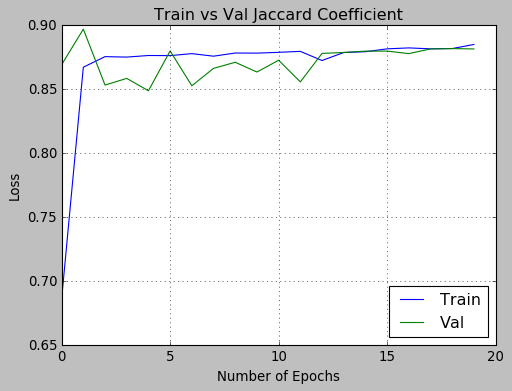

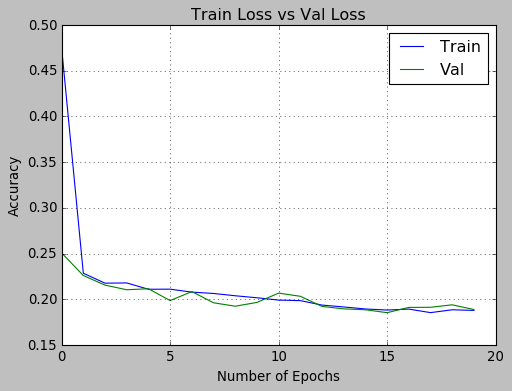

In [145]:
def plot_results(results):
    # extracting loss and accuracy from results
    train_jac=results['jaccard_coef']
    val_jac=results['val_jaccard_coef']
    train_acc=results['loss']
    val_acc=results['val_loss']
    # setting x axis as per number of epochs
    xc=range(len(results['loss']))
    
    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_jac)
    plt.plot(xc,val_jac)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Val Jaccard Coefficient')
    plt.grid(True)
    plt.legend(['Train','Val'],loc=4)
    plt.style.use(['classic'])
    
    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train Loss vs Val Loss')
    plt.grid(True)
    plt.legend(['Train','Val'])
    plt.style.use(['classic'])

plot_results(results)

From the plots we observe that we validation and training score for jaccard coefficient is close indicating we are neither underfitting nor overfitting the model at this stage. Also, since we used patience = 10, the training continued for 20 epochs as there were no consecutive 10 epochs where validation loss did not improve.

Defining function that generates the prediction mask for an given image id and model object as input to the function:

In [165]:
def predict_mask(img_id, model, img_dir = dat_dir, prob_thresh = None, with_prob = False):
    initial_pred_img = load_img(img_id, img_dir)
    pred_img_norm = norm_img(initial_pred_img)
    # since the model input are 240x240, therefore we will create 960x960 channel and use for prediction
    temp_pred = np.zeros((960, 960,8))
    temp_pred[:pred_img_norm.shape[0], :pred_img_norm.shape[1], :] = pred_img_norm[:,:,:]
    sub_imgs = []
    for i in range(4):
        for j in range(4):
            img_slice = temp_pred[i*240:(i+1)*240, j*240:(j+1)*240, :]
            sub_imgs.append(img_slice)
    pred_img = np.array(sub_imgs)
    # batch size can be tuned
    prediction = model.predict(pred_img, batch_size = 2)
    # considering predictions for none category
    model_pred = np.zeros((960, 960,opt_cls+1))
    for i in range(4):
        for j in range(4):
            model_pred[i*240:(i+1)*240, j*240:(j+1)*240, :] = prediction[i*4+j]
    # converting prediction based on softmax output
    # ignoring the prediction into 11th category as that means None of the 10 classes
    max_chnl_indx = np.argmax(model_pred[:,:,:-1], axis = 2)
    max_chnl_prob = np.max(model_pred[:,:,:-1], axis = 2)
    # final_model_pred will classify each pixel into a class output
    final_model_pred = np.zeros((960, 960,opt_cls))
    for i in range(opt_cls):
        # if prob_thresh is none, then we will consider a class with maximum probability as per softmax with minimum probability of 0.25. Note: None will be considered while checking for max prob class.
        if prob_thresh is None:
            final_model_pred[:,:,i] = ((max_chnl_indx == i) & (max_chnl_prob >= 0.25))*(1)
        else:
            # if prob_thresh is provided, should be a list of 10 entries for minimum classification probability for each class
            # the model will check against the threshold probability after identifying the best classification probability from model
            if len(prob_thresh) != 10:
                return "Pass threshold for each of 10 classes in order in a list"
            final_model_pred[:,:,i] = ((max_chnl_indx == i) & (max_chnl_prob >= prob_thresh[i]))*(1)
        
    # extracting image size output
    # if function called with_prob = True, then the actual prediction probabilities for the model will also be returned
    pred_mask = final_model_pred[:initial_pred_img.shape[0], :initial_pred_img.shape[1], :]
    if with_prob:
        # output for None category is not returned. To calculate subtract sum of probabilities across 10 channels from 1
        return pred_mask, model_pred[:initial_pred_img.shape[0], :initial_pred_img.shape[1], :opt_cls]
    else:
        return pred_mask

Using the above predict function to make prediction for image id - '6120_2_2'. If we want to see actual prediction probabilities then pass the argument with_prob = True to the function. We will try few probability thresholds to identify optimal value.

In [200]:
predictions = predict_mask('6120_2_2', unnet_model, prob_thresh = [0.07]*10)

Comparing the true mask of the image with the predicted mask:   

**Image 6120_2_2 - Class 1 - Buildings - Accepting at 0.07**

                  TRUE IMAGE              ============================>             PREDICTED IMAGE


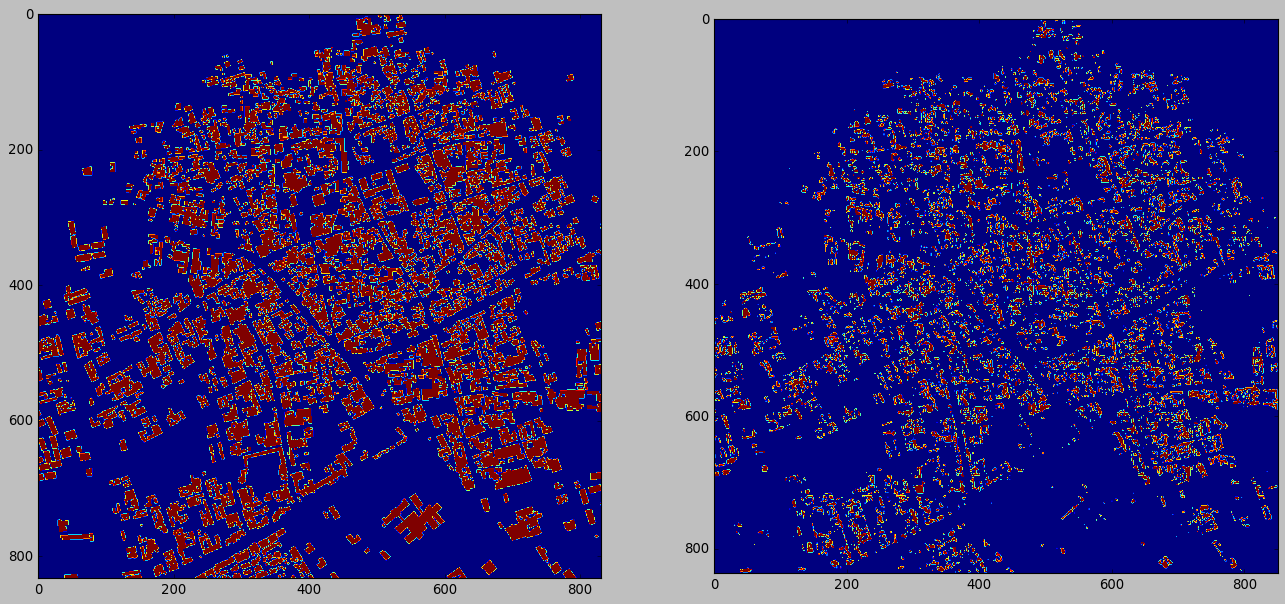

In [201]:
# loading true mask from directory of reconstructed image
data = np.load(dat_dir+'full_img_mask/img_6120.npz')
data = data[data.files[0]]
# since image is 6120_2_2 means for image 6120 (5x5 grids together), this will be 3rd one along both axis
true_mask = data[832*2:832*3,832*2:832*3,:]

print("                  TRUE IMAGE              ============================>             PREDICTED IMAGE")

plt_fig = plt.figure(figsize=(20,10))
plt_fig.add_subplot(1,2, 1)
plt.imshow(true_mask[:,:,0])
plt_fig.add_subplot(1,2, 2)
plt.imshow(predictions[:,:,0])
plt.show()


**Image 6120_2_2 - Class 1 - Buildings - Accepting at 0.05**

In [202]:
predictions = predict_mask('6120_2_2', unnet_model, prob_thresh = [0.05]*10)

                  TRUE IMAGE              ============================>             PREDICTED IMAGE


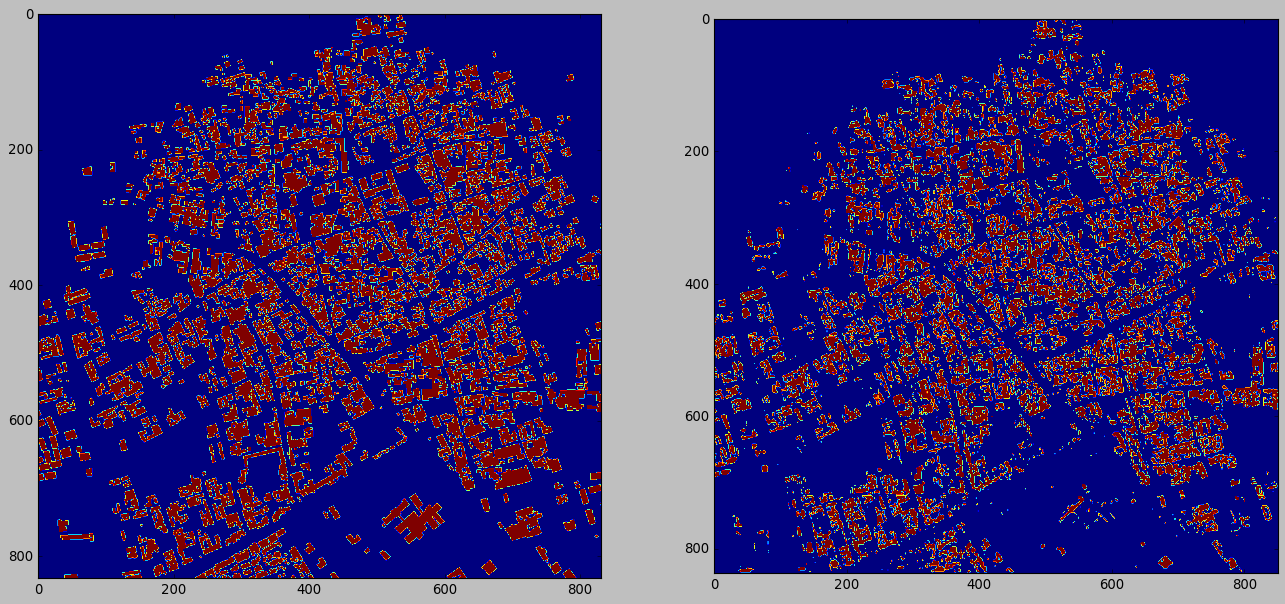

In [203]:
# loading true mask from directory of reconstructed image
data = np.load(dat_dir+'full_img_mask/img_6120.npz')
data = data[data.files[0]]
# since image is 6120_2_2 means for image 6120 (5x5 grids together), this will be 3rd one along both axis
true_mask = data[832*2:832*3,832*2:832*3,:]

print("                  TRUE IMAGE              ============================>             PREDICTED IMAGE")

plt_fig = plt.figure(figsize=(20,10))
plt_fig.add_subplot(1,2, 1)
plt.imshow(true_mask[:,:,0])
plt_fig.add_subplot(1,2, 2)
plt.imshow(predictions[:,:,0])
plt.show()

Identifying threshold probabilities for each class will be beneficial in understanding accuracy of the trained model. At threshold of 0.05 we get much clearer resemblance for class 1 as compared to threshold value of 0.07. Furthur similar threshold analysis for remaining 9 classes will help set up benchmark values for each class.

### Conclusion:

The neural network achieved 96.05% accuracy on the validation dataset and the jaccard coefficient score of 0.8813 (scales between 0-1, with 1 being the optimum value) after training for 20 epochs on Google Colab.  

11$^{th}$ class (accounting for none of the given 10 classes) added while training was the most dominating category in the training dataset and it would largely affect the training of the model. Note, the coded predict function handles the classifications going under this class and outputs the results for the 10 classes only to match the training labels. So, to furthur improve the model, we should create our own loss function that gives less weightage to the correct predictions on this 11$^{th}$ class and this can help in furthur improving the overall accuracy of the model. Also, augmenting data to include increase presence of these classes in the training data will improve efficiency.  

These possibilities should be furthur explored to improve prediction accuracy of the model.